In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt
import streamlit as st
from pyngrok import ngrok

In [3]:
df = pd.read_csv('ind_nifty500list.csv')

In [4]:
print("Initial Data Preview:")
print(df.head())

Initial Data Preview:
               Company Name                Industry     Symbol Series  \
0          360 ONE WAM Ltd.      Financial Services     360ONE     EQ   
1             3M India Ltd.             Diversified    3MINDIA     EQ   
2            ABB India Ltd.           Capital Goods        ABB     EQ   
3                  ACC Ltd.  Construction Materials        ACC     EQ   
4  ACME Solar Holdings Ltd.                   Power  ACMESOLAR     EQ   

      ISIN Code  
0  INE466L01038  
1  INE470A01017  
2  INE117A01022  
3  INE012A01025  
4  INE622W01025  


In [5]:
print("\nMissing Values Check:")
print(df.isnull().sum())


Missing Values Check:
Company Name    0
Industry        0
Symbol          0
Series          0
ISIN Code       0
dtype: int64


In [6]:
start_date = "2010-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

In [7]:
all_data = pd.DataFrame()

In [8]:
for symbol in df['Symbol']:
    try:
        print(f"Fetching data for {symbol}...")
        ticker = yf.Ticker(f"{symbol}.NS")
        hist = ticker.history(start=start_date, end=end_date)

        if not hist.empty:
            hist['Company Name'] = symbol
            hist = hist[['Close', 'Dividends', 'Company Name']]
            hist.reset_index(inplace=True)
            all_data = pd.concat([all_data, hist], ignore_index=True)
    except Exception as e:
        print(f"Error fetching {symbol}: {e}")

Fetching data for 360ONE...
Fetching data for 3MINDIA...
Fetching data for ABB...
Fetching data for ACC...
Fetching data for ACMESOLAR...
Fetching data for AIAENG...
Fetching data for APLAPOLLO...
Fetching data for AUBANK...
Fetching data for AADHARHFC...
Fetching data for AARTIIND...
Fetching data for AAVAS...
Fetching data for ABBOTINDIA...
Fetching data for ACE...
Fetching data for ADANIENSOL...
Fetching data for ADANIENT...
Fetching data for ADANIGREEN...
Fetching data for ADANIPORTS...
Fetching data for ADANIPOWER...
Fetching data for ATGL...
Fetching data for AWL...
Fetching data for ABCAPITAL...
Fetching data for ABFRL...
Fetching data for ABREL...
Fetching data for ABSLAMC...
Fetching data for AEGISLOG...
Fetching data for AFCONS...
Fetching data for AFFLE...
Fetching data for AJANTPHARM...
Fetching data for AKUMS...
Fetching data for APLLTD...
Fetching data for ALIVUS...
Fetching data for ALKEM...
Fetching data for ALKYLAMINE...
Fetching data for ALOKINDS...
Fetching data for 

In [9]:
all_data.rename(columns={'Close': 'Stock Price', 'Dividends': 'Dividend'}, inplace=True)

In [10]:
all_data['Total Return'] = all_data['Stock Price'] + all_data['Dividend']

In [11]:
def calculate_cagr(start_price, end_price, years):
    return (end_price / start_price) ** (1 / years) - 1

cagr_dict = {}
for symbol in df['Symbol']:
    stock_data = all_data[all_data['Company Name'] == symbol]
    if stock_data.empty:
        print(f"No data available for {symbol}, skipping...")
        continue

    start_price = stock_data.iloc[0]['Stock Price']
    end_price = stock_data.iloc[-1]['Stock Price']
    years = (stock_data['Date'].iloc[-1] - stock_data['Date'].iloc[0]).days / 365
    cagr_dict[symbol] = calculate_cagr(start_price, end_price, years)

cagr_df = pd.DataFrame(list(cagr_dict.items()), columns=['Company Name', 'CAGR'])

No data available for DUMMYSIEMS, skipping...


In [12]:
all_data['Daily Returns'] = all_data['Stock Price'].pct_change()
volatility = all_data.groupby('Company Name')['Daily Returns'].std() * (252 ** 0.5)

volatility_df = volatility.reset_index()
volatility_df.rename(columns={'Daily Returns': 'Volatility'}, inplace=True)

C:\Users\tiger\AppData\Local\Temp\ipykernel_27924\1500718884.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  all_data['Daily Returns'] = all_data['Stock Price'].pct_change()


In [13]:
final_data = pd.merge(all_data, cagr_df, on='Company Name', how='left')
final_data = pd.merge(final_data, volatility_df, on='Company Name', how='left')

In [14]:
final_data.to_csv("nifty500_analysis.csv", index=False)
print("✅ All data fetched, analyzed, and saved!")

✅ All data fetched, analyzed, and saved!


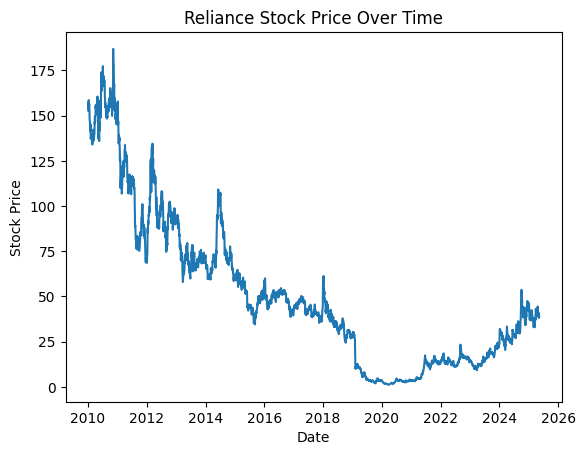

In [15]:
symbol_data = all_data[all_data['Company Name'] == 'RPOWER']
plt.plot(symbol_data['Date'], symbol_data['Stock Price'])
plt.title('Reliance Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

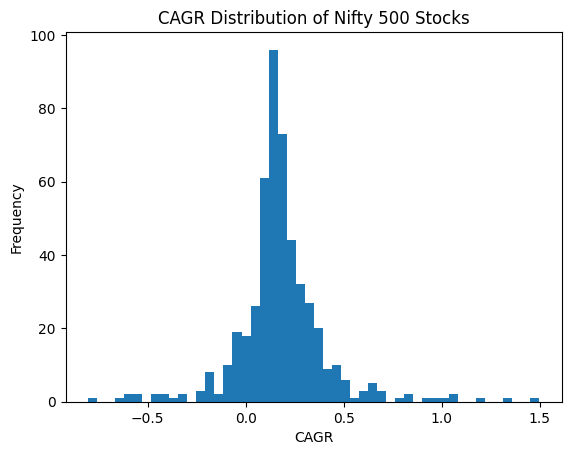

In [16]:
plt.hist(cagr_df['CAGR'], bins=50)
plt.title('CAGR Distribution of Nifty 500 Stocks')
plt.xlabel('CAGR')
plt.ylabel('Frequency')
plt.show()

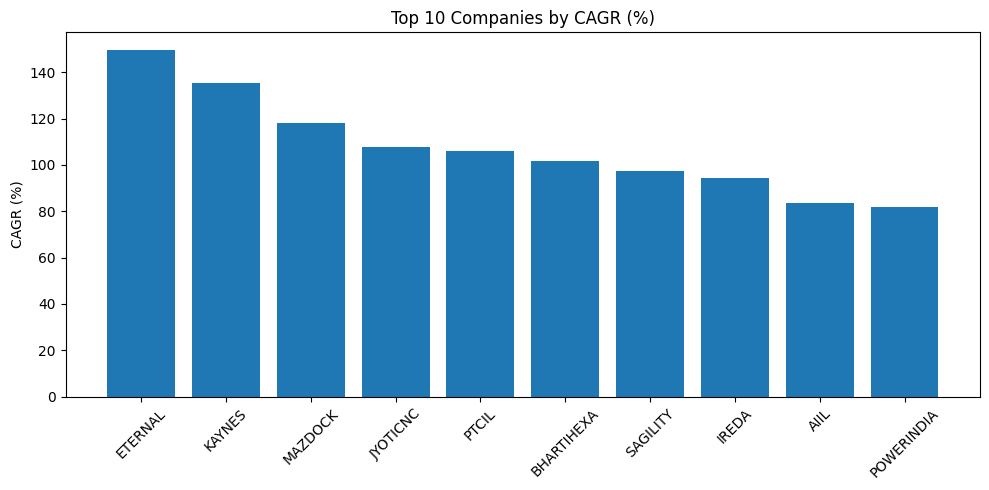

In [17]:
top_cagr = cagr_df.sort_values(by='CAGR', ascending=False).head(10)
plt.figure(figsize=(10, 5))
plt.bar(top_cagr['Company Name'], top_cagr['CAGR'] * 100)
plt.xticks(rotation=45)
plt.title('Top 10 Companies by CAGR (%)')
plt.ylabel('CAGR (%)')
plt.tight_layout()
plt.show()

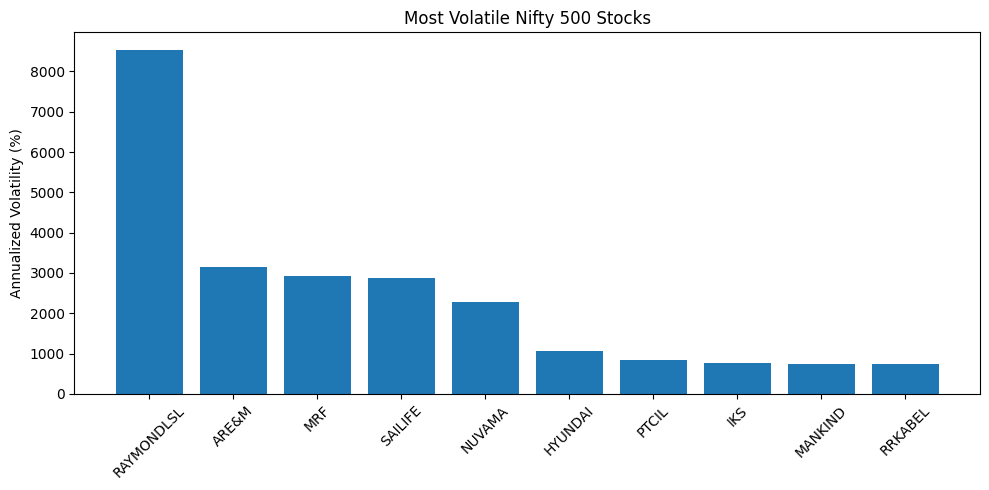

In [18]:
most_volatile = volatility_df.sort_values(by='Volatility', ascending=False).head(10)
plt.figure(figsize=(10, 5))
plt.bar(most_volatile['Company Name'], most_volatile['Volatility'] * 100)
plt.xticks(rotation=45)
plt.title('Most Volatile Nifty 500 Stocks')
plt.ylabel('Annualized Volatility (%)')
plt.tight_layout()
plt.show()

In [17]:
import subprocess
from pyngrok import ngrok
import time

# Step 1: Write the Streamlit app code to a file
code = '''
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Step 1: Load preprocessed data
final_data = pd.read_csv("ind_nifty500list.csv")  # Original company data
cagr_volatility_df = pd.read_csv("nifty500_analysis.csv")  # Data with CAGR and Volatility

# Step 2: Convert 'Date' column to datetime format - CORRECTED
# Handle ISO8601 format with timezone
cagr_volatility_df['Date'] = pd.to_datetime(cagr_volatility_df['Date'], format='ISO8601')
# Remove timezone information
cagr_volatility_df['Date'] = cagr_volatility_df['Date'].dt.tz_localize(None)

# Step 3: Remove duplicate rows for companies with same name
cagr_volatility_df = cagr_volatility_df.drop_duplicates(subset=['Company Name'], keep='first')

# Step 4: Streamlit App Title
st.title("📊 Nifty 500 Stock Performance Dashboard")

# Sidebar for selecting company - sorted alphabetically
company = st.sidebar.selectbox("Select a company", sorted(final_data['Company Name'].unique()))

# Filter data for the selected company
company_data = cagr_volatility_df[cagr_volatility_df['Company Name'] == company]

# Show company details and stock price trend
st.subheader(f"📈 Stock Price Trend: {company}")

if not company_data.empty:
    # Create figure with proper sizing
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Plot actual stock prices
    ax.plot(company_data['Date'], company_data['Stock Price'], 
            label='Stock Price', linewidth=2, color='steelblue')
    
    # Format x-axis dates properly
    date_format = DateFormatter("%b-%Y")
    ax.xaxis.set_major_formatter(date_format)
    plt.xticks(rotation=45)
    
    # Format y-axis
    ax.set_ylabel('Stock Price (₹)')
    ax.set_title(f"Stock Price of {company}")
    ax.grid(True, linestyle='--', alpha=0.7)
    fig.tight_layout()
    st.pyplot(fig)
    
    # Display metrics
    col1, col2 = st.columns(2)
    with col1:
        st.metric("📈 CAGR", f"{company_data['CAGR'].values[0] * 100:.2f}%")
    with col2:
        st.metric("📉 Volatility", f"{company_data['Volatility'].values[0] * 100:.2f}%")
else:
    st.warning("No data available for selected company")

# Summary Table for Top and Bottom Performers by CAGR
st.subheader("📋 Summary: Top & Bottom Performers")

# Get top and bottom performers
top_cagr = cagr_volatility_df.sort_values(by='CAGR', ascending=False).head(5)
bottom_cagr = cagr_volatility_df.sort_values(by='CAGR').head(5)

# Display in columns with improved formatting
col1, col2 = st.columns(2)
with col1:
    st.markdown("**🏆 Top 5 Performers (CAGR)**")
    st.dataframe(
        top_cagr[['Company Name', 'CAGR']]
        .style.format({"CAGR": "{:.2%}"})
        .background_gradient(cmap='Greens')
    )

with col2:
    st.markdown("**🚨 Bottom 5 Performers (CAGR)**")
    st.dataframe(
        bottom_cagr[['Company Name', 'CAGR']]
        .style.format({"CAGR": "{:.2%}"})
        .background_gradient(cmap='Reds')
    )
'''

# Step 2: Save the Streamlit code to a Python file
with open("dashboard_app.py", "w", encoding="utf-8") as f:
    f.write(code)

# Step 3: Set ngrok token and open a tunnel for Streamlit
ngrok.set_auth_token("2vnidcStEtI9beu2PzWGLwjg4UN_5uHcwThJDeh2wrzVCtTKp")
public_url = ngrok.connect(8501)  # Streamlit runs on port 8501 by default
print(f"🌐 Streamlit App URL: {public_url}")

# Step 4: Launch the Streamlit app
subprocess.Popen(["streamlit", "run", "dashboard_app.py"])

# Optional: Wait a few seconds to ensure the app starts
time.sleep(5)



🌐 Streamlit App URL: NgrokTunnel: "https://f727-2405-201-e029-20b5-400e-37fc-23b9-57e.ngrok-free.app" -> "http://localhost:8501"
